In [1]:
import json
import io
import random
import boto3

import xml.etree.ElementTree as ET
from tensorflow.keras.applications import resnet50

from annotation_helpers import get_annotations, save_augmented_manifest

### Prepare Dataset

* Convert XML to annotations


In [60]:
bucket = 'sagemaker-facemasks-object-detection'
prefix = 'annotations/'

s3 = boto3.client('s3')
paginator = s3.get_paginator('list_objects')

annotations = []
for page in paginator.paginate(Bucket=bucket, Prefix='annotations/'):
    for c in page['Contents']:
        key = c['Key']
        if '.xml' in key:
            obj = s3.get_object(Bucket=bucket, Key=key)
            xml = ET.fromstring(obj['Body'].read())
            annotations.append(get_annotations(xml))

In [57]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def read_image(bucket, prefix, img_file):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key=os.path.join(prefix, img_file))
    file_stream = io.BytesIO(obj['Body'].read())
    img=mpimg.imread(file_stream)
    plt.imshow(img)
    return img
    

def visualize_bbox(bucket, prefix, annotation, classes=[]):    
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        
        %matplotlib inline
        
        img_file = annotation['source-ref'].split('/')[-1]
        img=read_image(bucket, prefix, img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for ann in annotation['bounding-box']['annotations']:
            klass = ann['class_id']
            left = ann['left']
            top = ann['top']
            w = ann['width']
            h = ann['height']
            
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(left)
            ymin = int(top)
            xmax = int(left + w)
            ymax = int(top + h) 
            
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
                print(class_name)
            plt.gca().text(xmin, ymin - 2,
                            '{:s}'.format(class_name),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

without_mask
with_mask
without_mask


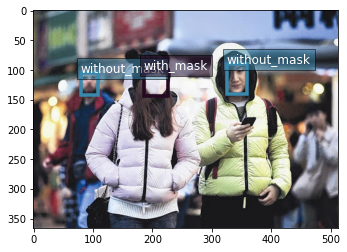

In [58]:
bucket = 'sagemaker-facemasks-object-detection'
prefix = 'images/'
visualize_bbox(bucket, prefix, annotations[0], classes={0: 'without_mask', 1: 'with_mask', 2: 'mask_weared_incorrect'})

In [64]:
random.seed(773)
random.shuffle(annotations)

split = round(len(annotations)*0.8)

train_annotations = annotations[:split]
val_annotations = annotations[split:]

save_augmented_manifest(train_annotations, 'training/augmented.manifest')
save_augmented_manifest(val_annotations, 'validation/augmented.manifest')